In [2]:
import tensorflow as tf
import zipfile39 as zf
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow_hub as tfhub
import os
import pandas as pd

In [3]:
(train,test),metadata = tfds.load("food101",
                                data_dir = "C:\\Users\\Harshvardhan Bhosale\\OneDrive\\Desktop\\Foodvision101",
                                split=["train","validation"],
                                as_supervised=True,
                                shuffle_files=True,
                                with_info=True)

# KNOWING DATA:
* getting the class names
* knowing the shapes of images
* visualizing data
* getting the data type
* getting the label shape
* checking for data normalization

### GETTING THE CLASS NAMES

In [4]:
class_names = metadata.features["label"].names
print(class_names[:10])

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito']


### KNOWING THE SHAPE OF THE IMAGES AND LABELS

In [5]:
i = train.take(1)
for image,label in i:
    print(f'SHAPE OF THE IMAGE IS: {image.shape}')
    print(f'SHAPE OF THE LABEL IS: {label.shape}')
    print(f'SHAPE OF THE LABEL IS: {label}')
    print(f'CLASS NAME IS: {class_names[label.numpy()]}')

SHAPE OF THE IMAGE IS: (512, 288, 3)
SHAPE OF THE LABEL IS: ()
SHAPE OF THE LABEL IS: 93
CLASS NAME IS: steak


### VISUALIZING DATA

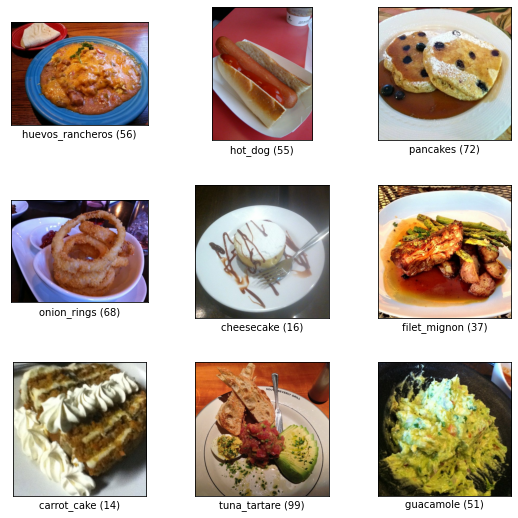

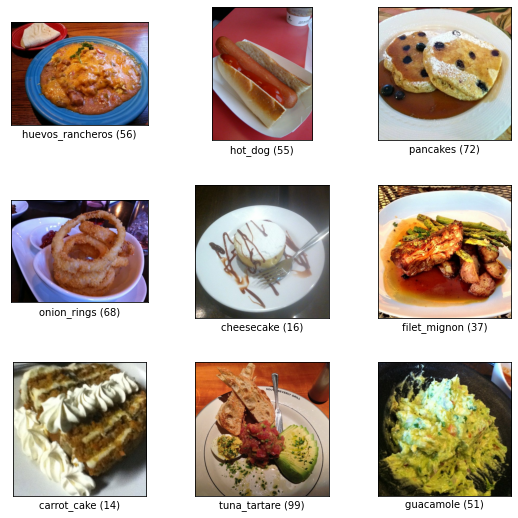

In [6]:
tfds.show_examples(train,metadata)

### CHECKING FOR DATA NORMALIZATION

In [7]:
tf.reduce_max(image),tf.reduce_min(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=255>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=0>)

# THINGS WE KNOW ABOUT OUR DATA:
* data type is 'unit8', we have to cast it to 'float32'
* data is not normalized
* data doesn't have proper shape
* labels are not one hot encoded

### MAKING A FUNCTION TO PREPROCESS OUR DATA

In [8]:
def preprocessing_data(image, label):
    img = tf.image.resize(image,[256,256])
    return tf.dtypes.cast(img,tf.float32), label
#we don't have to normalize our data since we are going to use efficientnet B0 

### PREPROCESSING DATA USING [PREFETCH](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) AND OTHER [METHODS](https://www.tensorflow.org/guide/data_performance#best_practice_summary)

In [9]:
train = train.map(map_func=preprocessing_data,num_parallel_calls=tf.data.AUTOTUNE)
train = train.shuffle(buffer_size = 1000).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
test = test.map(map_func=preprocessing_data,num_parallel_calls=tf.data.AUTOTUNE)
test = test.shuffle(buffer_size=1000).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE).cache()

In [10]:
train,test

(<PrefetchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int64)>,
 <CacheDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int64)>)

# CREATING CALLBACKS
* model checkpoint callback
* tensorboard callback

In [11]:
from helperfuncs import tensor_board_callback
checkpoint_path = "model_checkpoint.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy",
                                                     save_best_only=True,
                                                     save_weights_only=False,
                                                     verbose=0)

# SETTING [MIXED PRECISION](https://www.tensorflow.org/guide/mixed_precision)

In [13]:
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy("mixed_float16")
mixed_precision.set_global_policy(policy)

# BUILDING FEATURE EXTRACTION MODEL

In [12]:
from tensorflow.keras import layers
base_layer = tf.keras.applications.efficientnet.EfficientNetB0(include_top = False)
base_layer.trainable = False
#we do not need a preprocessing layer as efficient net already has one
inputs = tf.keras.Input(shape=(256,256,3),
                        name="input_layer")
x = base_layer(inputs,training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax",dtype = tf.float32)(x)
model = tf.keras.Model(inputs,outputs)

In [13]:
#our labels are not one-hot encoded, so we will use sparsecategoricalcrossentropy
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
             optimizer = tf.keras.optimizers.Adam(),
             metrics = "accuracy")
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 256, 256, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 activation (Activation)     (None, 101)               0         
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_____________________________________________

In [14]:
history = model.fit(train,
                   epochs=3,
                   steps_per_epoch=len(train),
                   validation_data = test,
                   validation_steps = int(0.2*len(test)),
                   callbacks = [model_checkpoint,tensor_board_callback(dirname="C:\\Users\\Harshvardhan Bhosale\\OneDrive\\Desktop\\Foodvision101",
                                                                      experimentname="efficientnetfeatureextract")])
# model = tf.keras.models.load_model(checkpoint_path)

Epoch 1/3


c:\users\harshvardhan bhosale\onedrive\desktop\foodvision101\venv1\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


2368/2368 [==============================] - ETA: 0s - loss: 1.7967 - accuracy: 0.5656INFO:tensorflow:Assets written to: model_checkpoint.ckpt\assets


INFO:tensorflow:Assets written to: model_checkpoint.ckpt\assets
c:\users\harshvardhan bhosale\onedrive\desktop\foodvision101\venv1\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
c:\users\harshvardhan bhosale\onedrive\desktop\foodvision101\venv1\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


2368/2368 [==============================] - 161s 63ms/step - loss: 1.7967 - accuracy: 0.5656 - val_loss: 1.1977 - val_accuracy: 0.6863
Epoch 2/3
2368/2368 [==============================] - ETA: 0s - loss: 1.2643 - accuracy: 0.6738INFO:tensorflow:Assets written to: model_checkpoint.ckpt\assets


INFO:tensorflow:Assets written to: model_checkpoint.ckpt\assets
c:\users\harshvardhan bhosale\onedrive\desktop\foodvision101\venv1\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


2368/2368 [==============================] - 154s 65ms/step - loss: 1.2643 - accuracy: 0.6738 - val_loss: 1.0789 - val_accuracy: 0.7045


c:\users\harshvardhan bhosale\onedrive\desktop\foodvision101\venv1\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 3/3
2368/2368 [==============================] - ETA: 0s - loss: 1.1140 - accuracy: 0.7091INFO:tensorflow:Assets written to: model_checkpoint.ckpt\assets


INFO:tensorflow:Assets written to: model_checkpoint.ckpt\assets
c:\users\harshvardhan bhosale\onedrive\desktop\foodvision101\venv1\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
c:\users\harshvardhan bhosale\onedrive\desktop\foodvision101\venv1\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


2368/2368 [==============================] - 153s 64ms/step - loss: 1.1140 - accuracy: 0.7091 - val_loss: 1.0442 - val_accuracy: 0.7170


# EVALUATING FEATURE EXTRACTION MODEL

In [15]:
feature_extract_eval = model.evaluate(test)
feature_extract_eval

790/790 [==============================] - 43s 53ms/step - loss: 1.0464 - accuracy: 0.71653s - loss: 1


[1.0464259386062622, 0.7165148258209229]

In [16]:
y_pred = model.predict(test)

In [17]:
test_pred = y_pred.argmax(axis=1)
test_pred,test_pred.shape

(array([30, 70,  8, ..., 27, 45,  6], dtype=int64), (25250,))

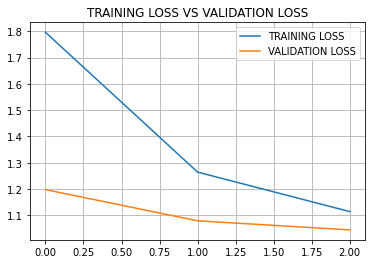

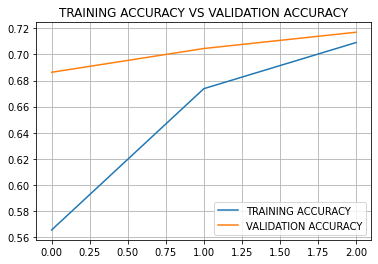

In [18]:
from helperfuncs import plot_curves
plot_curves(history)

In [17]:
y_labels = []
for image,label in test.unbatch():
    y_labels.append(label.numpy())

In [18]:
len(y_labels)

25250

In [21]:
from helperfuncs import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_labels,test_pred)

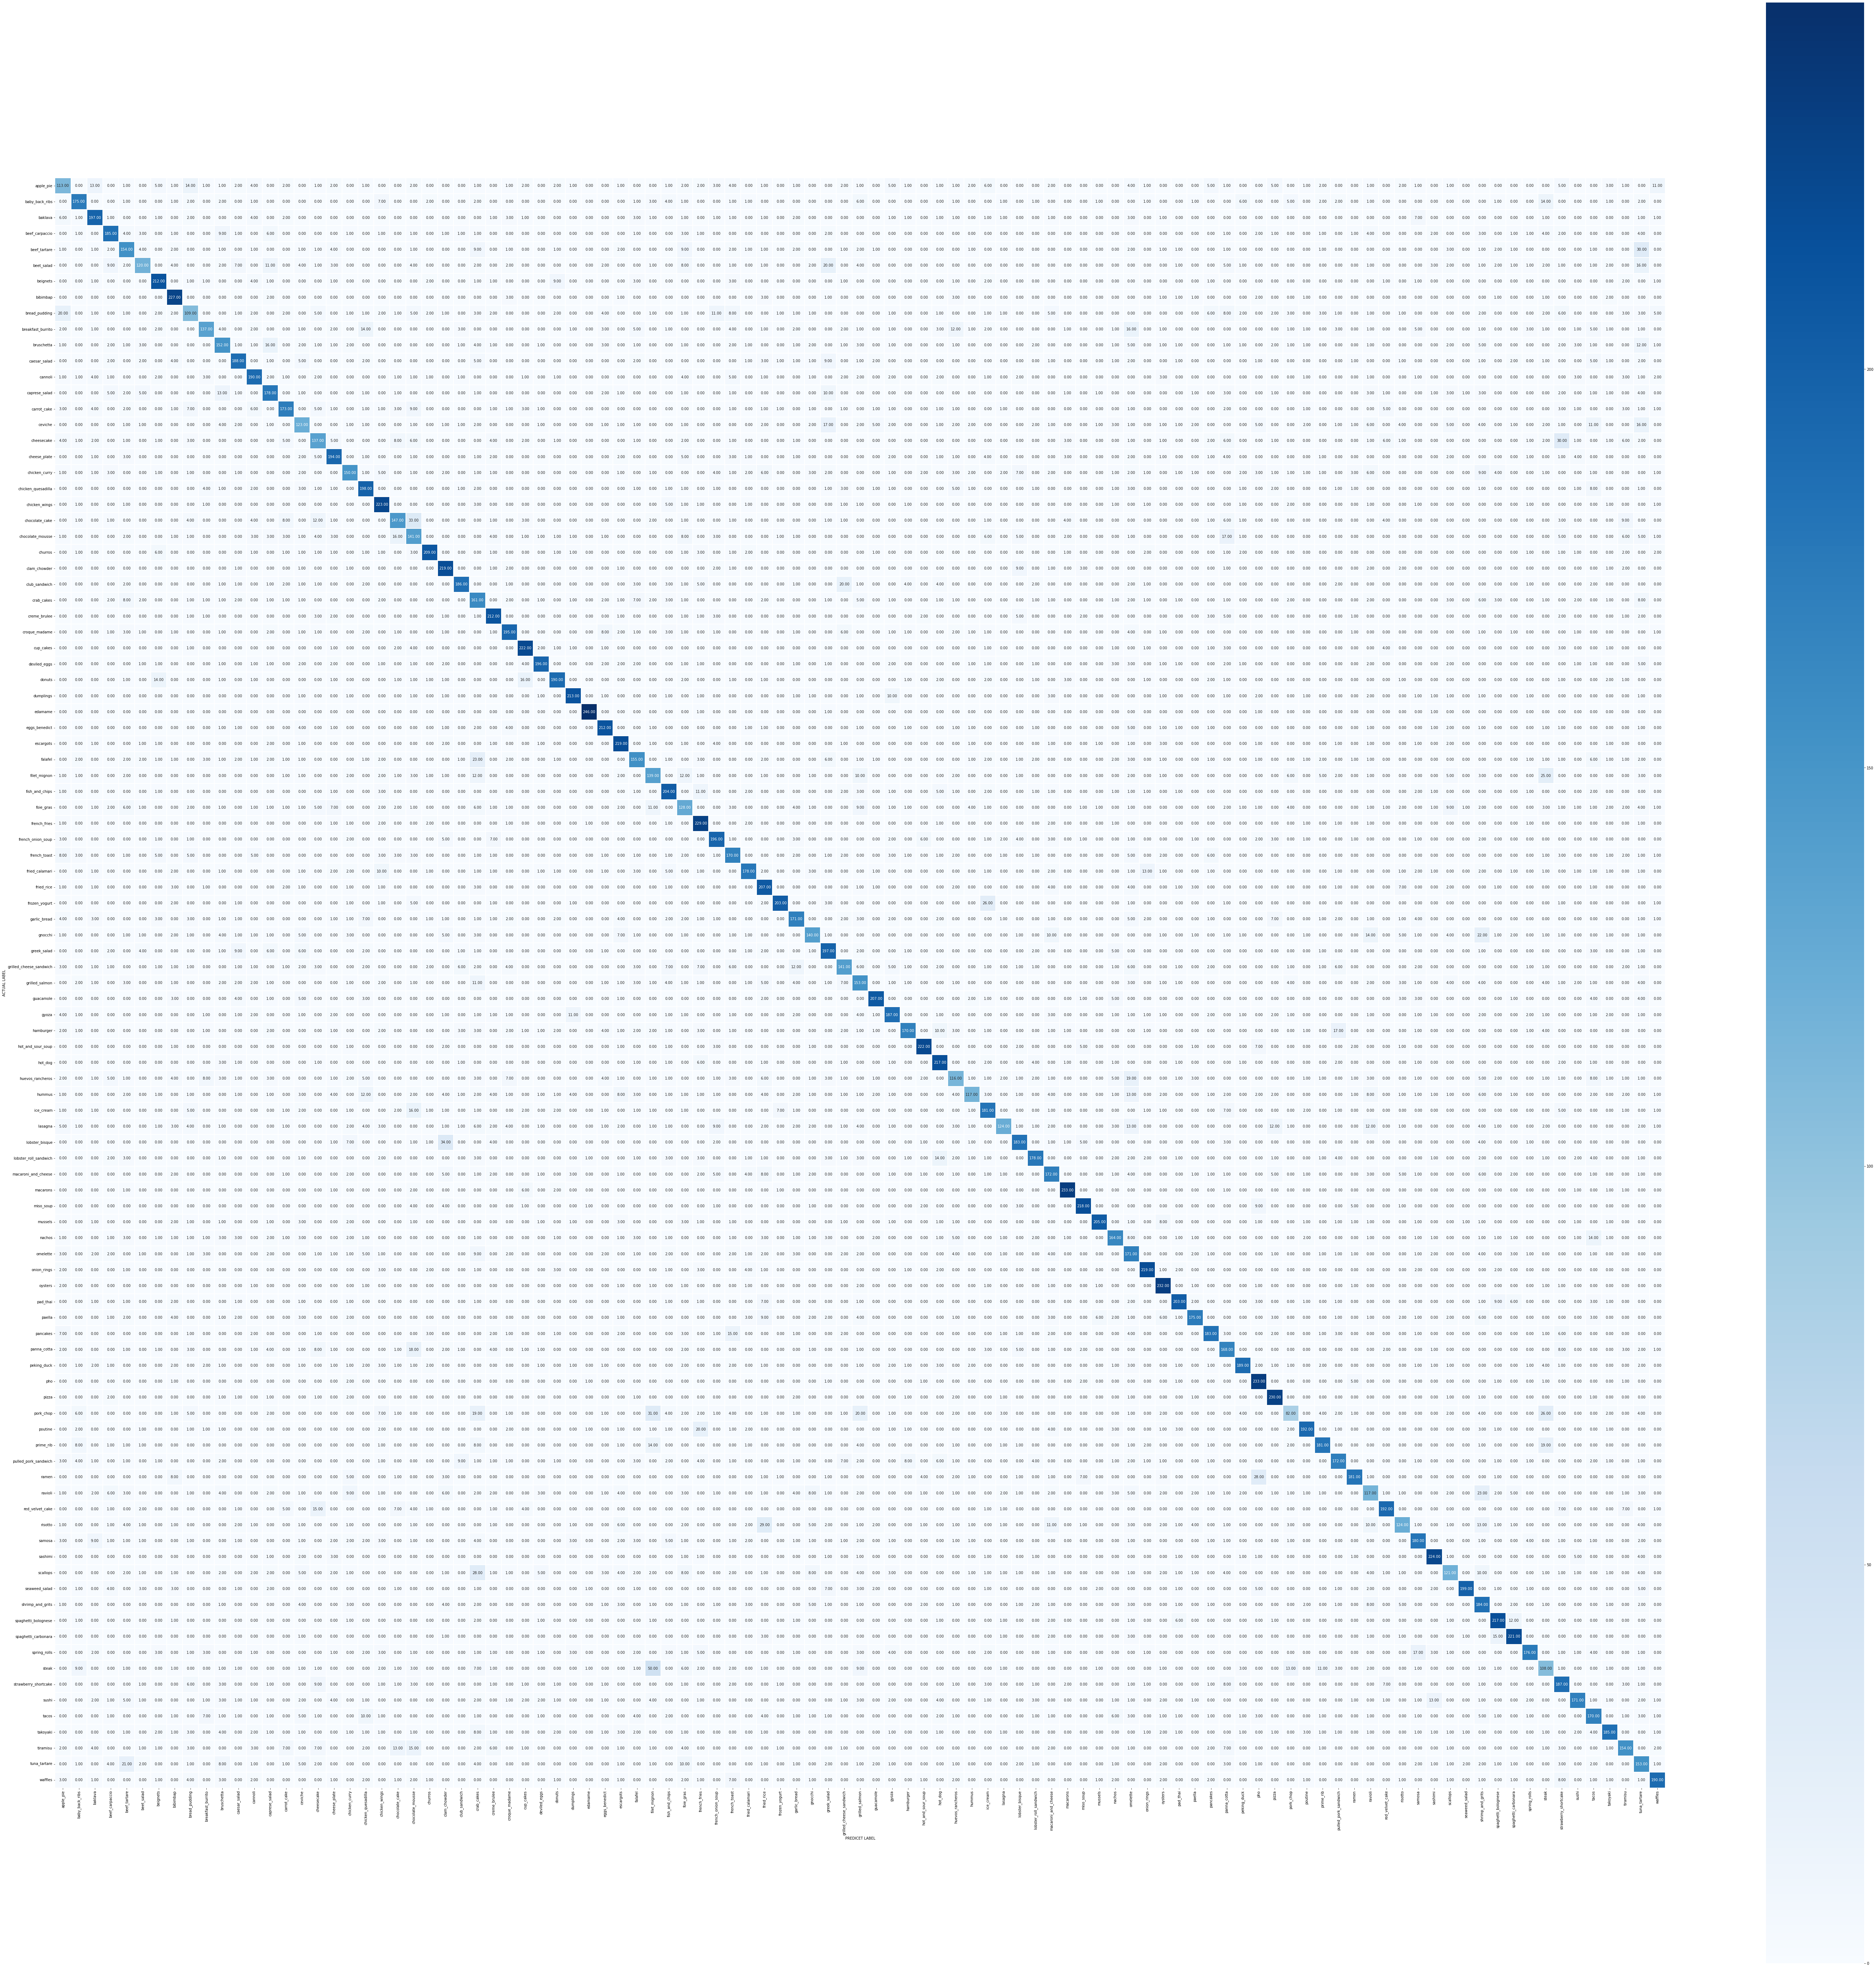

In [22]:
plot_confusion_matrix(cm,class_names,(100,100))

In [23]:
from sklearn.metrics import classification_report
report = classification_report(y_labels,test_pred,output_dict = True)

In [24]:
report

{'0': {'precision': 0.509009009009009,
  'recall': 0.452,
  'f1-score': 0.4788135593220339,
  'support': 250},
 '1': {'precision': 0.7743362831858407,
  'recall': 0.7,
  'f1-score': 0.7352941176470588,
  'support': 250},
 '2': {'precision': 0.7462121212121212,
  'recall': 0.788,
  'f1-score': 0.7665369649805447,
  'support': 250},
 '3': {'precision': 0.7312252964426877,
  'recall': 0.74,
  'f1-score': 0.73558648111332,
  'support': 250},
 '4': {'precision': 0.5923076923076923,
  'recall': 0.616,
  'f1-score': 0.6039215686274509,
  'support': 250},
 '5': {'precision': 0.718562874251497,
  'recall': 0.48,
  'f1-score': 0.5755395683453238,
  'support': 250},
 '6': {'precision': 0.7794117647058824,
  'recall': 0.848,
  'f1-score': 0.8122605363984675,
  'support': 250},
 '7': {'precision': 0.7566666666666667,
  'recall': 0.908,
  'f1-score': 0.8254545454545456,
  'support': 250},
 '8': {'precision': 0.5369458128078818,
  'recall': 0.436,
  'f1-score': 0.4812362030905077,
  'support': 250},


In [25]:
class_f1scores = {}
for k,v in report.items():
    if(k=='accuracy'):
        break
    class_f1scores[class_names[int(k)]] = v['f1-score']

In [26]:
df_f1scores = pd.DataFrame({"CLASS_NAMES":list(class_f1scores.keys()),
                            "F1_SCORES": list(class_f1scores.values())}).sort_values("F1_SCORES",ascending=False)
df_f1scores

CLASS_NAMES  F1_SCORES
33            edamame   0.978131
63           macarons   0.919132
54  hot_and_sour_soup   0.891566
64          miso_soup   0.875502
88      seaweed_salad   0.872807
..                ...        ...
82            ravioli   0.481481
8       bread_pudding   0.481236
0           apple_pie   0.478814
93              steak   0.438134
77          pork_chop   0.423773

[101 rows x 2 columns]

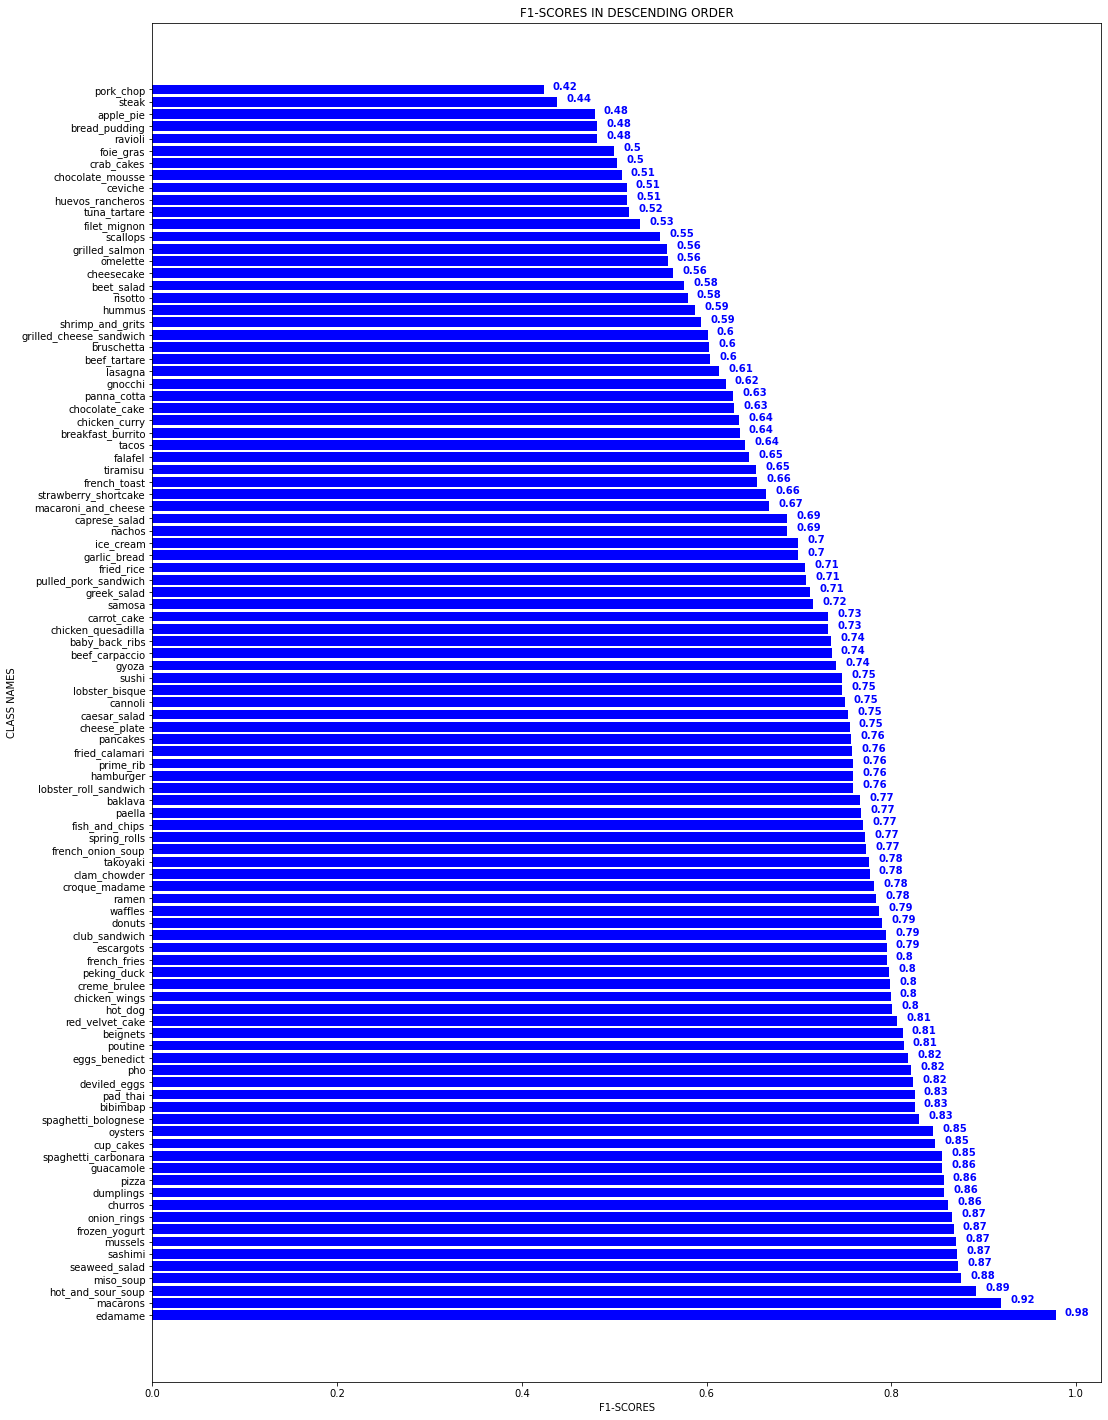

In [27]:
fig,ax = plt.subplots(figsize=(17,25))
scores = plt.barh(df_f1scores["CLASS_NAMES"],df_f1scores["F1_SCORES"],color='blue')
plt.xlabel("F1-SCORES")
plt.ylabel("CLASS NAMES")
plt.title("F1-SCORES IN DESCENDING ORDER")
for i, v in enumerate(df_f1scores["F1_SCORES"]):
  ax.text(v + 0.01 , i , str(np.round(v,decimals=2)), color='blue', fontweight='bold')

# FINE TUNING THE MODEL
* TRAINING A MODEL WITHOUT LEARNING SCHEDULER AND EARLY STOPPING -'model_ft'
* TRAINING A MODEL WITH LEARNING SCHEDULER AND EARLY STOPPING -'model_ft_lres'

In [28]:
model_ft = tf.keras.models.load_model(checkpoint_path)

In [29]:
model_ft.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 256, 256, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 activation (Activation)     (None, 101)               0         
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_____________________________________________

In [30]:
for layer in model_ft.layers:
    print(layer.name,layer.trainable)

input_layer True
efficientnetb0 False
global_average_pooling2d True
dense True
activation True


In [31]:
base_layer.trainable = True
for layer in base_layer.layers[:-10]:
    layer.trainable = False

In [32]:
for layer in base_layer.layers:
    print(layer.name,layer.trainable)

input_1 False
rescaling False
normalization False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_dwconv False
block2b_bn False
block2b_activation False
block2b_se_squeeze False
block2b_se_reshape False
block2b_se_reduce False
block2b_se_expand False
block2b_se_excite False
block2b_project_conv False
blo

In [33]:
model_ft.layers[1].trainable = True
for layer in model_ft.layers[1].layers[:-10]:
    layer.trainable = False

In [34]:
for layer in model_ft.layers:
    print(layer.trainable)

True
True
True
True
True


In [35]:
for layer in model_ft.layers[1].layers:
    print(layer.trainable)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

In [36]:
model_ft.compile(loss="sparse_categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics = "accuracy")

In [37]:
model_ft.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 256, 256, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 activation (Activation)     (None, 101)               0         
                                                                 
Total params: 4,178,952
Trainable params: 1,022,613
Non-trainable params: 3,156,339
___________________________________________

### TRAINING WITHOUT LEARNING SCHEDULER AND EARLY STOPPING

In [38]:
history_ft = model_ft.fit(train,
                         epochs = 6,
                         steps_per_epoch = len(train),
                         initial_epoch = history.epoch[-1],
                         validation_data = test,
                         validation_steps = int(0.2*len(test)),
                         callbacks=[tensor_board_callback(dirname="C:\\Users\\Harshvardhan Bhosale\\OneDrive\\Desktop\\Foodvision101",
                                                                      experimentname="efficientnetfeatureextract")])
# model_ft.load("firstfinetunemodel")

c:\users\harshvardhan bhosale\onedrive\desktop\foodvision101\venv1\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 3/6
2368/2368 [==============================] - 152s 62ms/step - loss: 0.9209 - accuracy: 0.7566 - val_loss: 0.9584 - val_accuracy: 0.7381
Epoch 4/6
2368/2368 [==============================] - 134s 56ms/step - loss: 0.7783 - accuracy: 0.7943 - val_loss: 0.9249 - val_accuracy: 0.7462
Epoch 5/6
2368/2368 [==============================] - 135s 57ms/step - loss: 0.6729 - accuracy: 0.8216 - val_loss: 0.9087 - val_accuracy: 0.7526
Epoch 6/6
2368/2368 [==============================] - 134s 57ms/step - loss: 0.5836 - accuracy: 0.8468 - val_loss: 0.9243 - val_accuracy: 0.7464


### EVALUATION OF FIRST FINE TUNED MODEL

In [39]:
fine_tune_eval1 = model_ft.evaluate(test)

790/790 [==============================] - 93s 118ms/step - loss: 0.9244 - accuracy: 0.7487


In [40]:
y_pred = model_ft.predict(test)

In [41]:
test_pred_ft1 = y_pred.argmax(axis=1)
test_pred_ft1,test_pred_ft1.shape

(array([30, 70,  8, ...,  8, 45,  6], dtype=int64), (25250,))

In [42]:
cm1 = confusion_matrix(y_labels,test_pred_ft1)

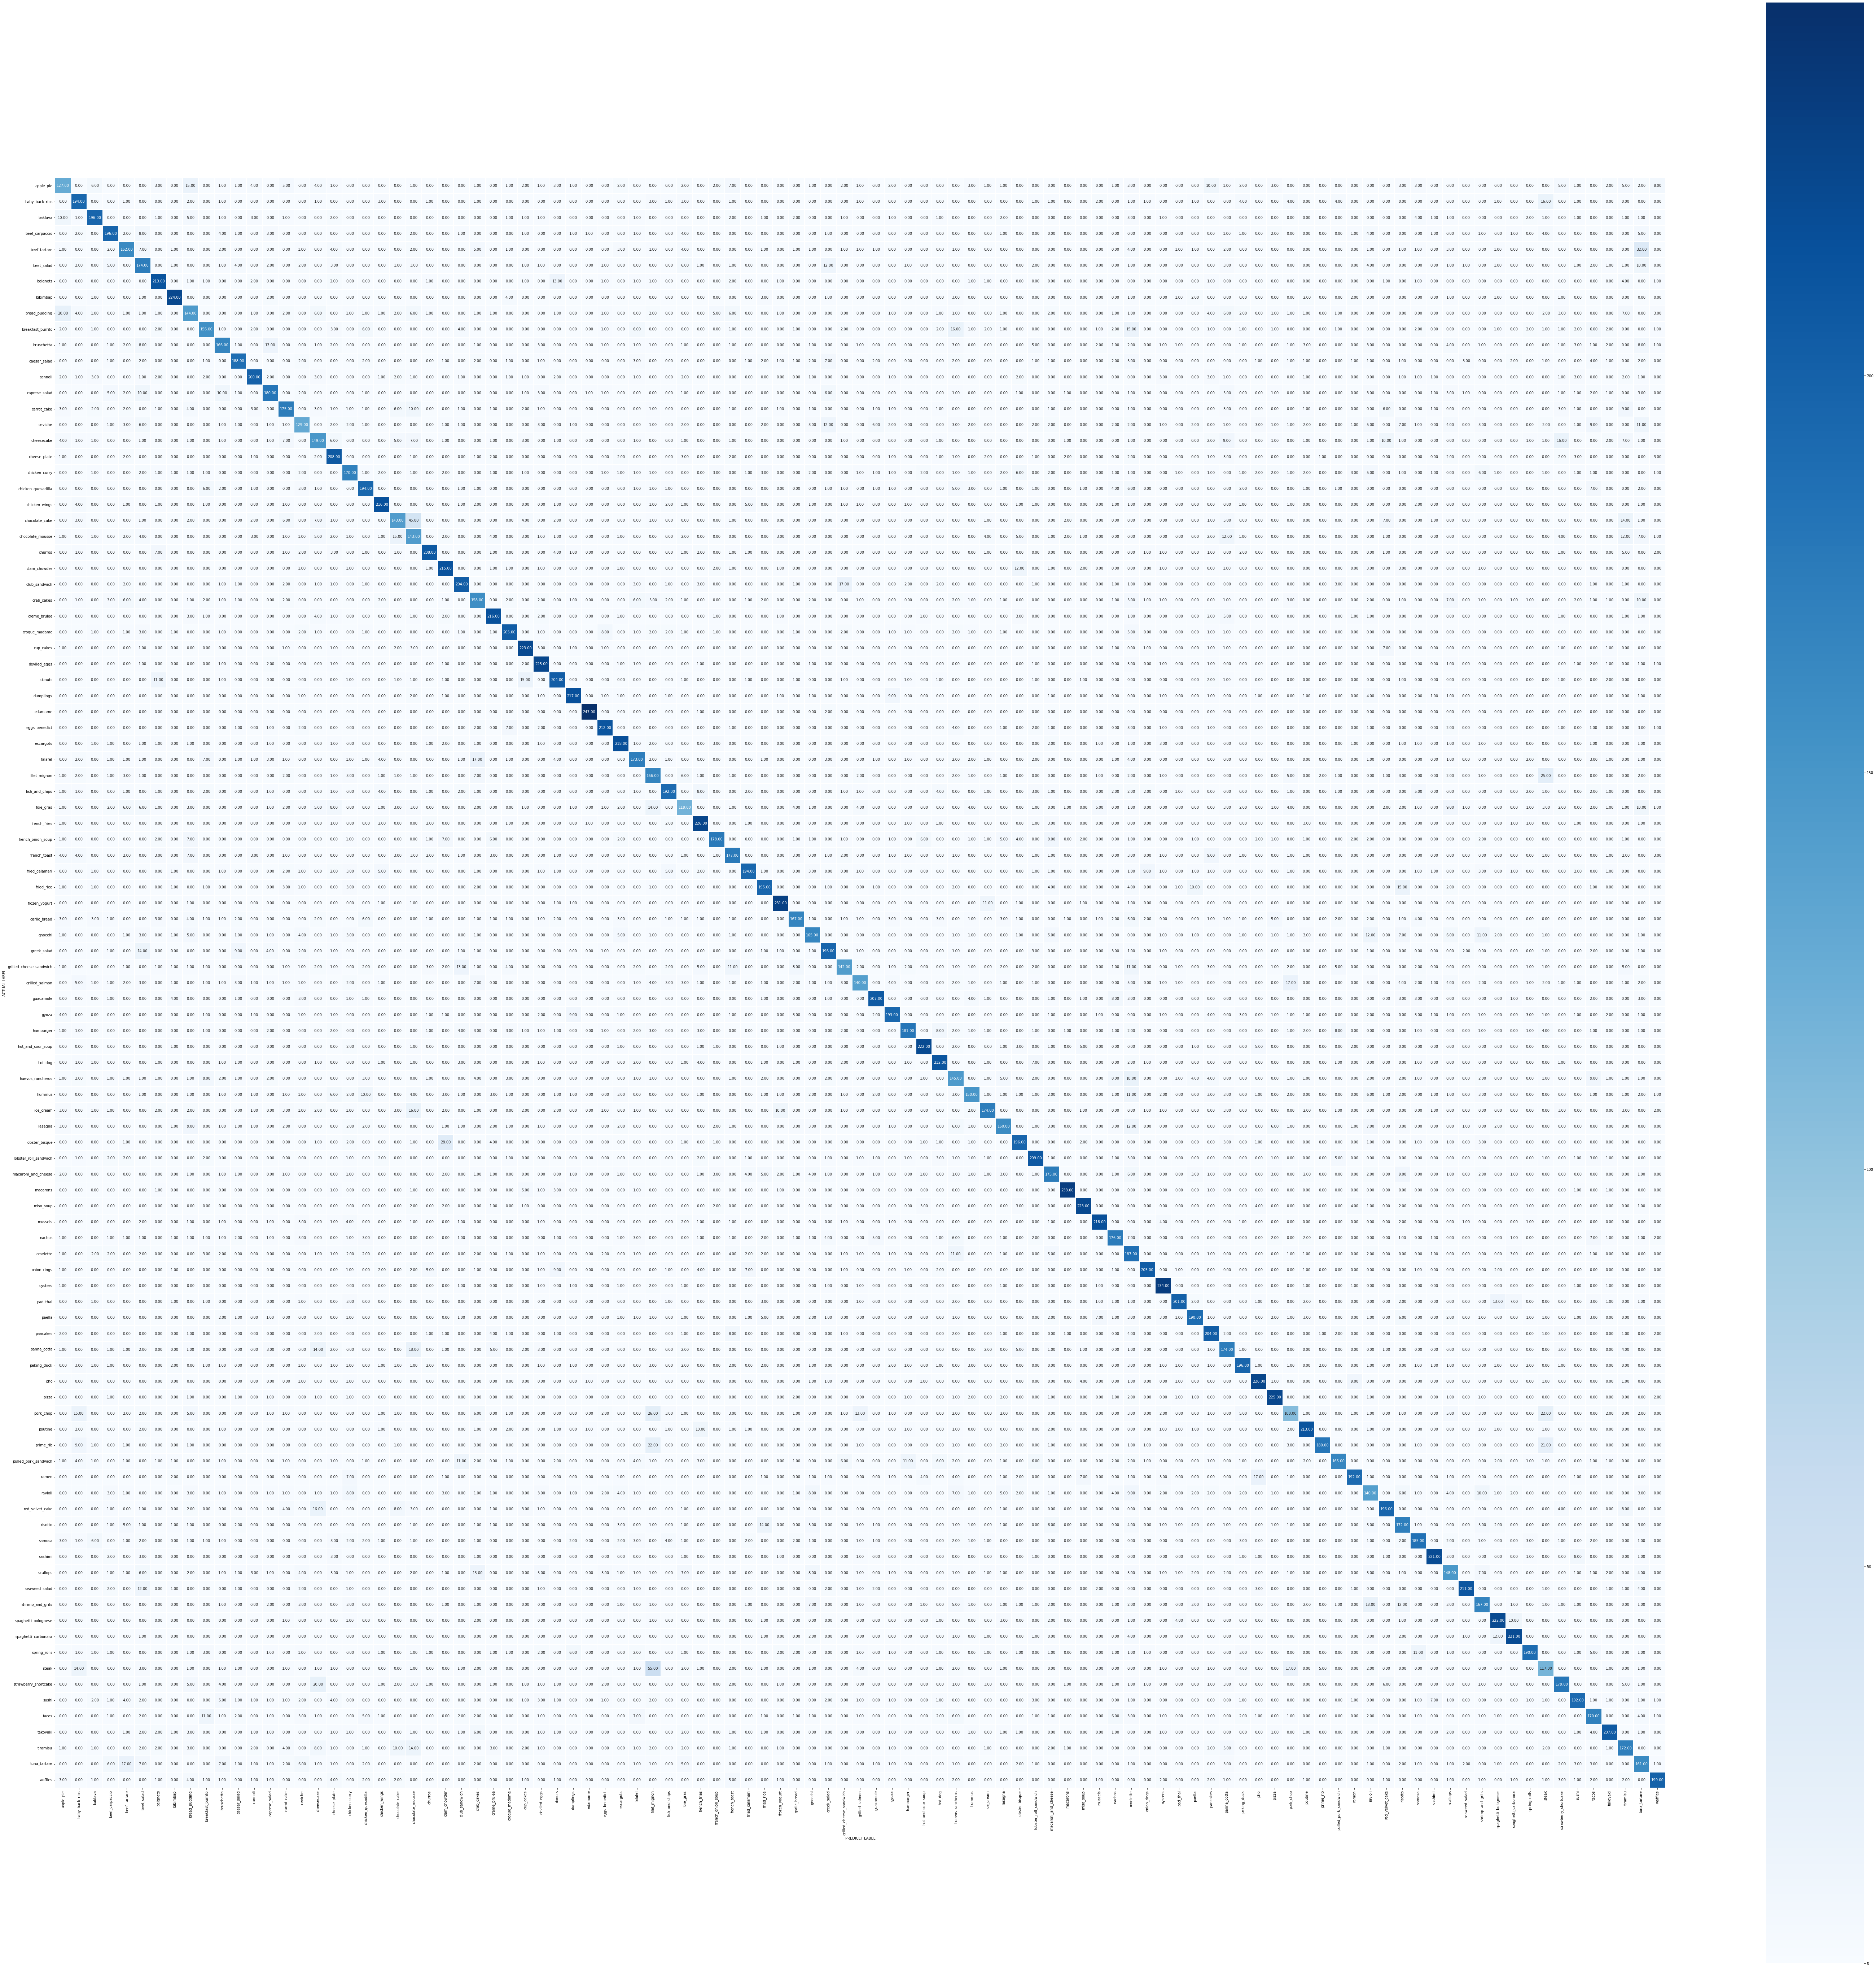

In [43]:
plot_confusion_matrix(cm1,class_names,figsize=(100,100))

In [44]:
report_ft1 = classification_report(y_labels,test_pred_ft1,output_dict=True)
report_ft1

{'0': {'precision': 0.5852534562211982,
  'recall': 0.508,
  'f1-score': 0.5438972162740899,
  'support': 250},
 '1': {'precision': 0.6879432624113475,
  'recall': 0.776,
  'f1-score': 0.7293233082706767,
  'support': 250},
 '2': {'precision': 0.8166666666666667,
  'recall': 0.784,
  'f1-score': 0.7999999999999999,
  'support': 250},
 '3': {'precision': 0.7777777777777778,
  'recall': 0.784,
  'f1-score': 0.7808764940239045,
  'support': 250},
 '4': {'precision': 0.6585365853658537,
  'recall': 0.648,
  'f1-score': 0.653225806451613,
  'support': 250},
 '5': {'precision': 0.5403726708074534,
  'recall': 0.696,
  'f1-score': 0.6083916083916084,
  'support': 250},
 '6': {'precision': 0.8007518796992481,
  'recall': 0.852,
  'f1-score': 0.8255813953488372,
  'support': 250},
 '7': {'precision': 0.896,
  'recall': 0.896,
  'f1-score': 0.8960000000000001,
  'support': 250},
 '8': {'precision': 0.555984555984556,
  'recall': 0.576,
  'f1-score': 0.5658153241650296,
  'support': 250},
 '9': {

In [45]:
class_f1scores = {}
for k,v in report_ft1.items():
    if(k=='accuracy'):
        break
    class_f1scores[class_names[int(k)]] = v['f1-score']

In [46]:
df_f1scores = pd.DataFrame({"class_names": list(class_f1scores.keys()),
                           "f1-scores": list(class_f1scores.values())}).sort_values("f1-scores",ascending=False)
df_f1scores.head(10)

class_names  f1-scores
33            edamame   0.984064
63           macarons   0.937626
54  hot_and_sour_soup   0.900609
45      frozen_yogurt   0.900585
7            bibimbap   0.896000
86            sashimi   0.894737
88      seaweed_salad   0.890295
64          miso_soup   0.888446
69            oysters   0.879699
65            mussels   0.877264

Text(0.5, 1.0, 'F1-SCORES IN DESCENDING ORDER')

<Figure size 432x288 with 0 Axes>

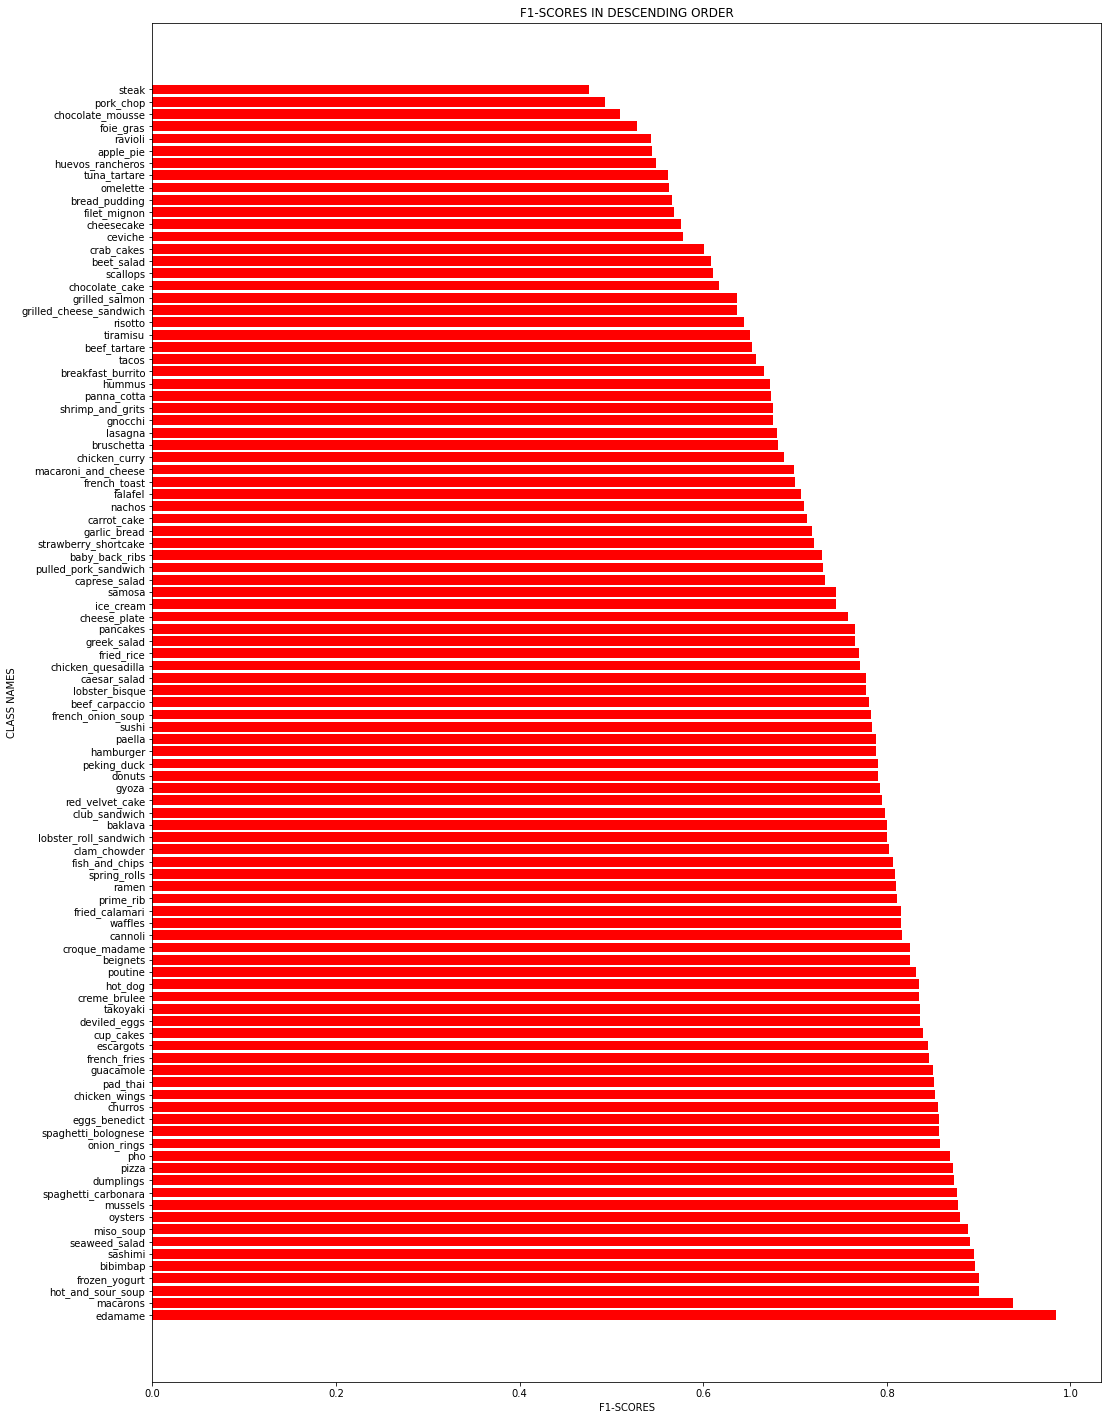

In [47]:
plt.figure()
ax,fig = plt.subplots(figsize = (17,25))
scores = plt.barh(df_f1scores["class_names"],df_f1scores["f1-scores"],color="Red")
plt.xlabel("F1-SCORES")
plt.ylabel("CLASS NAMES")
plt.title("F1-SCORES IN DESCENDING ORDER")

In [48]:
model_ft.save('firstfinetunedmodel')

INFO:tensorflow:Assets written to: firstfinetunedmodel\assets


INFO:tensorflow:Assets written to: firstfinetunedmodel\assets
c:\users\harshvardhan bhosale\onedrive\desktop\foodvision101\venv1\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
c:\users\harshvardhan bhosale\onedrive\desktop\foodvision101\venv1\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


# FINE TUNING MODEL USING EARLY STOPPING AND LEARNING RATE SCHEDULER

In [19]:
# creating learning rate scheduler
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)
# creating early stopping callback
es = tf.keras.callbacks.EarlyStopping("val_loss",
                                     patience = 3)

In [50]:
model_ftlres = tf.keras.models.load_model(checkpoint_path)

In [51]:
model_ftlres.layers[1].trainable = True
for layer in model_ftlres.layers[1].layers[:-10]:
    layer.trainable = False

In [52]:
for layer in model_ftlres.layers:
    print(layer.name,layer.trainable)

input_layer True
efficientnetb0 True
global_average_pooling2d True
dense True
activation True


In [53]:
model_ftlres.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 256, 256, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 activation (Activation)     (None, 101)               0         
                                                                 
Total params: 4,178,952
Trainable params: 1,022,613
Non-trainable params: 3,156,339
___________________________________________

In [54]:
history_ft2 = model_ftlres.fit(train,
                          epochs = 100,
                          steps_per_epoch = len(train),
                          initial_epoch = history.epoch[-1],
                          validation_data = test,
                          validation_steps = int(0.2*len(test)),
                          callbacks=[es,reduce_lr,tensor_board_callback(dirname="C:\\Users\\Harshvardhan Bhosale\\OneDrive\\Desktop\\Foodvision101",
                                                                      experimentname="efficientnetfeatureextract")])

Epoch 3/100
2368/2368 [==============================] - 146s 59ms/step - loss: 1.0214 - accuracy: 0.7323 - val_loss: 1.0271 - val_accuracy: 0.7174 - lr: 0.0010
Epoch 4/100
2368/2368 [==============================] - 127s 53ms/step - loss: 0.9456 - accuracy: 0.7523 - val_loss: 1.0137 - val_accuracy: 0.7249 - lr: 0.0010
Epoch 5/100
2368/2368 [==============================] - 127s 54ms/step - loss: 0.8883 - accuracy: 0.7655 - val_loss: 1.0100 - val_accuracy: 0.7227 - lr: 0.0010
Epoch 6/100
2368/2368 [==============================] - 128s 54ms/step - loss: 0.8412 - accuracy: 0.7775 - val_loss: 1.0109 - val_accuracy: 0.7219 - lr: 0.0010
Epoch 7/100
2368/2368 [==============================] - ETA: 0s - loss: 0.8013 - accuracy: 0.7898
Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
2368/2368 [==============================] - 128s 54ms/step - loss: 0.8013 - accuracy: 0.7898 - val_loss: 1.0178 - val_accuracy: 0.7239 - lr: 0.0010
Epoch 8/100
2368/2368 [====

In [58]:
history_ft3 = model_ftlres.fit(train,
                          epochs = 20,
                          steps_per_epoch = len(train),
                          initial_epoch = history_ft2.epoch[-1],
                          validation_data = test,
                          validation_steps = int(0.2*len(test)),
                          callbacks=[es,reduce_lr,tensor_board_callback(dirname="C:\\Users\\Harshvardhan Bhosale\\OneDrive\\Desktop\\Foodvision101",
                                                                      experimentname="efficientnetfeatureextract")])

Epoch 14/20
2368/2368 [==============================] - 141s 59ms/step - loss: 0.6471 - accuracy: 0.8413 - val_loss: 0.9797 - val_accuracy: 0.7310 - lr: 8.0000e-06
Epoch 15/20
2368/2368 [==============================] - 126s 53ms/step - loss: 0.6468 - accuracy: 0.8412 - val_loss: 0.9796 - val_accuracy: 0.7310 - lr: 8.0000e-06
Epoch 16/20
2368/2368 [==============================] - 126s 53ms/step - loss: 0.6465 - accuracy: 0.8414 - val_loss: 0.9797 - val_accuracy: 0.7312 - lr: 8.0000e-06
Epoch 17/20
2367/2368 [============================>.] - ETA: 0s - loss: 0.6462 - accuracy: 0.8413
Epoch 00017: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.
2368/2368 [==============================] - 126s 53ms/step - loss: 0.6462 - accuracy: 0.8413 - val_loss: 0.9797 - val_accuracy: 0.7306 - lr: 8.0000e-06
Epoch 18/20
2368/2368 [==============================] - 127s 53ms/step - loss: 0.6451 - accuracy: 0.8418 - val_loss: 0.9797 - val_accuracy: 0.7308 - lr: 1.6000e-06


### EVALUATION OF THE 2ND FINE TUNED MODEL

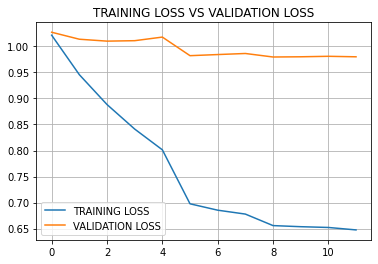

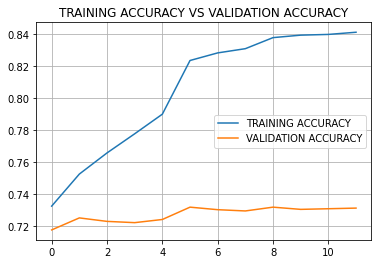

In [61]:
plot_curves(history_ft2)

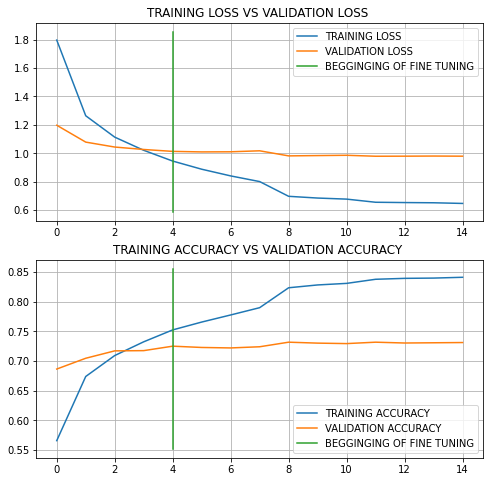

In [62]:
from helperfuncs import compare_history
compare_history(history,history_ft2)

In [63]:
fine_tune_eval2 = model_ftlres.evaluate(test)
fine_tune_eval2

790/790 [==============================] - 89s 112ms/step - loss: 0.9843 - accuracy: 0.7322


[0.9843270182609558, 0.7321584224700928]

In [64]:
model_ftlres.save("finalfinetuning")

INFO:tensorflow:Assets written to: finalfinetuning\assets


INFO:tensorflow:Assets written to: finalfinetuning\assets
c:\users\harshvardhan bhosale\onedrive\desktop\foodvision101\venv1\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
c:\users\harshvardhan bhosale\onedrive\desktop\foodvision101\venv1\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


# BUILDING A MODEL TRAINED WITH DATA AUGUMENTATION AND EFFICIENTNETB4

### BUILDING DATA AUGUMENTATION LAYER

In [14]:
from tensorflow.keras.layers.experimental import preprocessing
data_aug_layer = tf.keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomRotation(0.2)
])

### BUILDING A FEATURE EXTRACTION MODEL

In [15]:
inputs = tf.keras.Input(shape=(256,256,3))
x = data_aug_layer(inputs)
base_layer = tf.keras.applications.efficientnet.EfficientNetB4(include_top=False)
base_layer.trainable = False
x = base_layer(x,training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(len(class_names))(x)
outputs = tf.keras.layers.Activation("softmax",dtype=tf.float32)(x)
model_data_aug = tf.keras.models.Model(inputs,outputs)

71696384/71686520 [==============================] - 15s 0us/step


In [16]:
model_data_aug.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 efficientnetb4 (Functional)  (None, None, None, 1792)  17673823 
                                                                 
 global_average_pooling2d (G  (None, 1792)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 101)               181093    
                                                                 
 activation (Activation)     (None, 101)               0         
                                                             

In [21]:
model_data_aug.compile(loss="sparse_categorical_crossentropy",
                      optimizer = tf.keras.optimizers.Adam(),
                      metrics="accuracy")

In [22]:
history_data_aug = model_data_aug.fit(train,
                                     epochs=5,
                                     steps_per_epoch=len(train),
                                     validation_data=test,
                                     validation_steps = int(0.15*len(test)),
                                     callbacks = [reduce_lr,es,tensor_board_callback(dirname="C:\\Users\\Harshvardhan Bhosale\\OneDrive\\Desktop\\Foodvision101",
                                                                      experimentname="efficientnetB4dataaugfeatureextract")])

c:\users\harshvardhan bhosale\onedrive\desktop\foodvision101\venv1\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/5
2368/2368 [==============================] - 341s 138ms/step - loss: 2.1882 - accuracy: 0.4669 - val_loss: 1.3864 - val_accuracy: 0.6377 - lr: 0.0010
Epoch 2/5
2368/2368 [==============================] - 284s 120ms/step - loss: 1.7457 - accuracy: 0.5566 - val_loss: 1.2851 - val_accuracy: 0.6602 - lr: 0.0010
Epoch 3/5
2368/2368 [==============================] - 279s 118ms/step - loss: 1.6242 - accuracy: 0.5855 - val_loss: 1.2584 - val_accuracy: 0.6698 - lr: 0.0010
Epoch 4/5
2368/2368 [==============================] - 271s 114ms/step - loss: 1.5629 - accuracy: 0.5975 - val_loss: 1.2297 - val_accuracy: 0.6642 - lr: 0.0010
Epoch 5/5
2368/2368 [==============================] - 268s 113ms/step - loss: 1.5090 - accuracy: 0.6093 - val_loss: 1.1987 - val_accuracy: 0.6772 - lr: 0.0010


### FINE TUNING THE FEATURE EXTRACTION LAYER

In [24]:
# UNFREEZING LAYERS
for i,layer in enumerate(model_data_aug.layers):
    print(i,layer.name,layer.trainable)

0 input_1 True
1 sequential True
2 efficientnetb4 False
3 global_average_pooling2d True
4 dense True
5 activation True


In [25]:
model_data_aug.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 efficientnetb4 (Functional)  (None, None, None, 1792)  17673823 
                                                                 
 global_average_pooling2d (G  (None, 1792)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 101)               181093    
                                                                 
 activation (Activation)     (None, 101)               0         
                                                             

In [26]:
model_data_aug.layers[2].trainable = True
for layer in model_data_aug.layers[2].layers[:-10]:
    layer.trainable = False
model_data_aug.compile(loss="sparse_categorical_crossentropy",
                      optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
                      metrics="accuracy")
model_data_aug.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 efficientnetb4 (Functional)  (None, None, None, 1792)  17673823 
                                                                 
 global_average_pooling2d (G  (None, 1792)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 101)               181093    
                                                                 
 activation (Activation)     (None, 101)               0         
                                                             

In [28]:
history_data_aug_ft = model_data_aug.fit(train,
                                        epochs = 15,
                                        steps_per_epoch = len(train),
                                        initial_epoch = history_data_aug.epoch[-1],
                                        validation_data = test,
                                        validation_steps = int(0.2*len(test)),
                                        callbacks=[reduce_lr,es,tensor_board_callback(dirname="C:\\Users\\Harshvardhan Bhosale\\OneDrive\\Desktop\\Foodvision101",
                                                                      experimentname="efficientnetB4dataaugfinetune")])

Epoch 5/15
2368/2368 [==============================] - 285s 117ms/step - loss: 1.3701 - accuracy: 0.6413 - val_loss: 1.0799 - val_accuracy: 0.7035 - lr: 1.0000e-04
Epoch 6/15
2368/2368 [==============================] - 273s 115ms/step - loss: 1.2516 - accuracy: 0.6698 - val_loss: 1.0364 - val_accuracy: 0.7174 - lr: 1.0000e-04
Epoch 7/15
2368/2368 [==============================] - 274s 116ms/step - loss: 1.1600 - accuracy: 0.6903 - val_loss: 1.0352 - val_accuracy: 0.7188 - lr: 1.0000e-04
Epoch 8/15
2368/2368 [==============================] - 273s 115ms/step - loss: 1.0865 - accuracy: 0.7078 - val_loss: 1.0062 - val_accuracy: 0.7271 - lr: 1.0000e-04
Epoch 9/15
2368/2368 [==============================] - 272s 115ms/step - loss: 1.0207 - accuracy: 0.7219 - val_loss: 0.9980 - val_accuracy: 0.7251 - lr: 1.0000e-04
Epoch 10/15
2368/2368 [==============================] - 273s 115ms/step - loss: 0.9643 - accuracy: 0.7347 - val_loss: 0.9988 - val_accuracy: 0.7280 - lr: 1.0000e-04
Epoch 11/

In [29]:
eval1 = model_data_aug.evaluate(test)

790/790 [==============================] - 132s 166ms/step - loss: 1.0008 - accuracy: 0.7276


In [44]:
model_data_aug.layers[2].trainable = True
for layer in model_data_aug.layers[2].layers[:-20]:
    layer.trainable = False

In [45]:
model_data_aug.compile(loss="sparse_categorical_crossentropy",
                      optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
                      metrics="accuracy")

In [46]:
for layer in model_data_aug.layers[2].layers:
    print(layer.name,layer.trainable)

input_2 False
rescaling False
normalization False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block1b_dwconv False
block1b_bn False
block1b_activation False
block1b_se_squeeze False
block1b_se_reshape False
block1b_se_reduce False
block1b_se_expand False
block1b_se_excite False
block1b_project_conv False
block1b_project_bn False
block1b_drop False
block1b_add False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv Fal

In [47]:
model_data_aug.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 efficientnetb4 (Functional)  (None, None, None, 1792)  17673823 
                                                                 
 global_average_pooling2d (G  (None, 1792)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 101)               181093    
                                                                 
 activation (Activation)     (None, 101)               0         
                                                             

In [48]:
history_data_aug_ft2 = model_data_aug.fit(train,
                                        epochs = 50,
                                        steps_per_epoch = len(train),
                                        initial_epoch = history_data_aug_ft.epoch[-1],
                                        validation_data = test,
                                        validation_steps = int(0.2*len(test)),
                                        callbacks=[reduce_lr,es,tensor_board_callback(dirname="C:\\Users\\Harshvardhan Bhosale\\OneDrive\\Desktop\\Foodvision101",
                                                                      experimentname="efficientnetB4dataaugfinetune2")])

Epoch 14/50
2368/2368 [==============================] - 305s 123ms/step - loss: 0.8114 - accuracy: 0.7697 - val_loss: 1.0277 - val_accuracy: 0.7251 - lr: 1.0000e-04
Epoch 15/50
2368/2368 [==============================] - 279s 118ms/step - loss: 0.7308 - accuracy: 0.7901 - val_loss: 1.0273 - val_accuracy: 0.7296 - lr: 1.0000e-04
Epoch 16/50
2368/2368 [==============================] - 280s 118ms/step - loss: 0.6569 - accuracy: 0.8102 - val_loss: 1.0327 - val_accuracy: 0.7273 - lr: 1.0000e-04
Epoch 17/50
2368/2368 [==============================] - ETA: 0s - loss: 0.5867 - accuracy: 0.8272
Epoch 00017: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 280s 118ms/step - loss: 0.5867 - accuracy: 0.8272 - val_loss: 1.0728 - val_accuracy: 0.7229 - lr: 1.0000e-04
Epoch 18/50
2368/2368 [==============================] - 279s 118ms/step - loss: 0.4343 - accuracy: 0.8733 - val_loss: 1.0671 - val_accuracy: 0.7387 - lr: 2.0000e-05


### EVALUATING THE MODEL

In [49]:
model_data_aug.evaluate(test)

790/790 [==============================] - 125s 157ms/step - loss: 1.0702 - accuracy: 0.7322


[1.070220708847046, 0.7321979999542236]

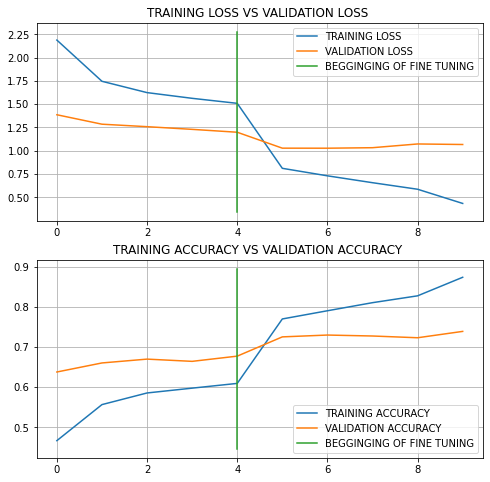

In [51]:
compare_history(history_data_aug,history_data_aug_ft2)

In [53]:
from sklearn.metrics import confusion_matrix
y_pred = model_data_aug.predict(test)
final_pred = y_pred.argmax(axis=1)
cm = confusion_matrix(y_labels,final_pred)

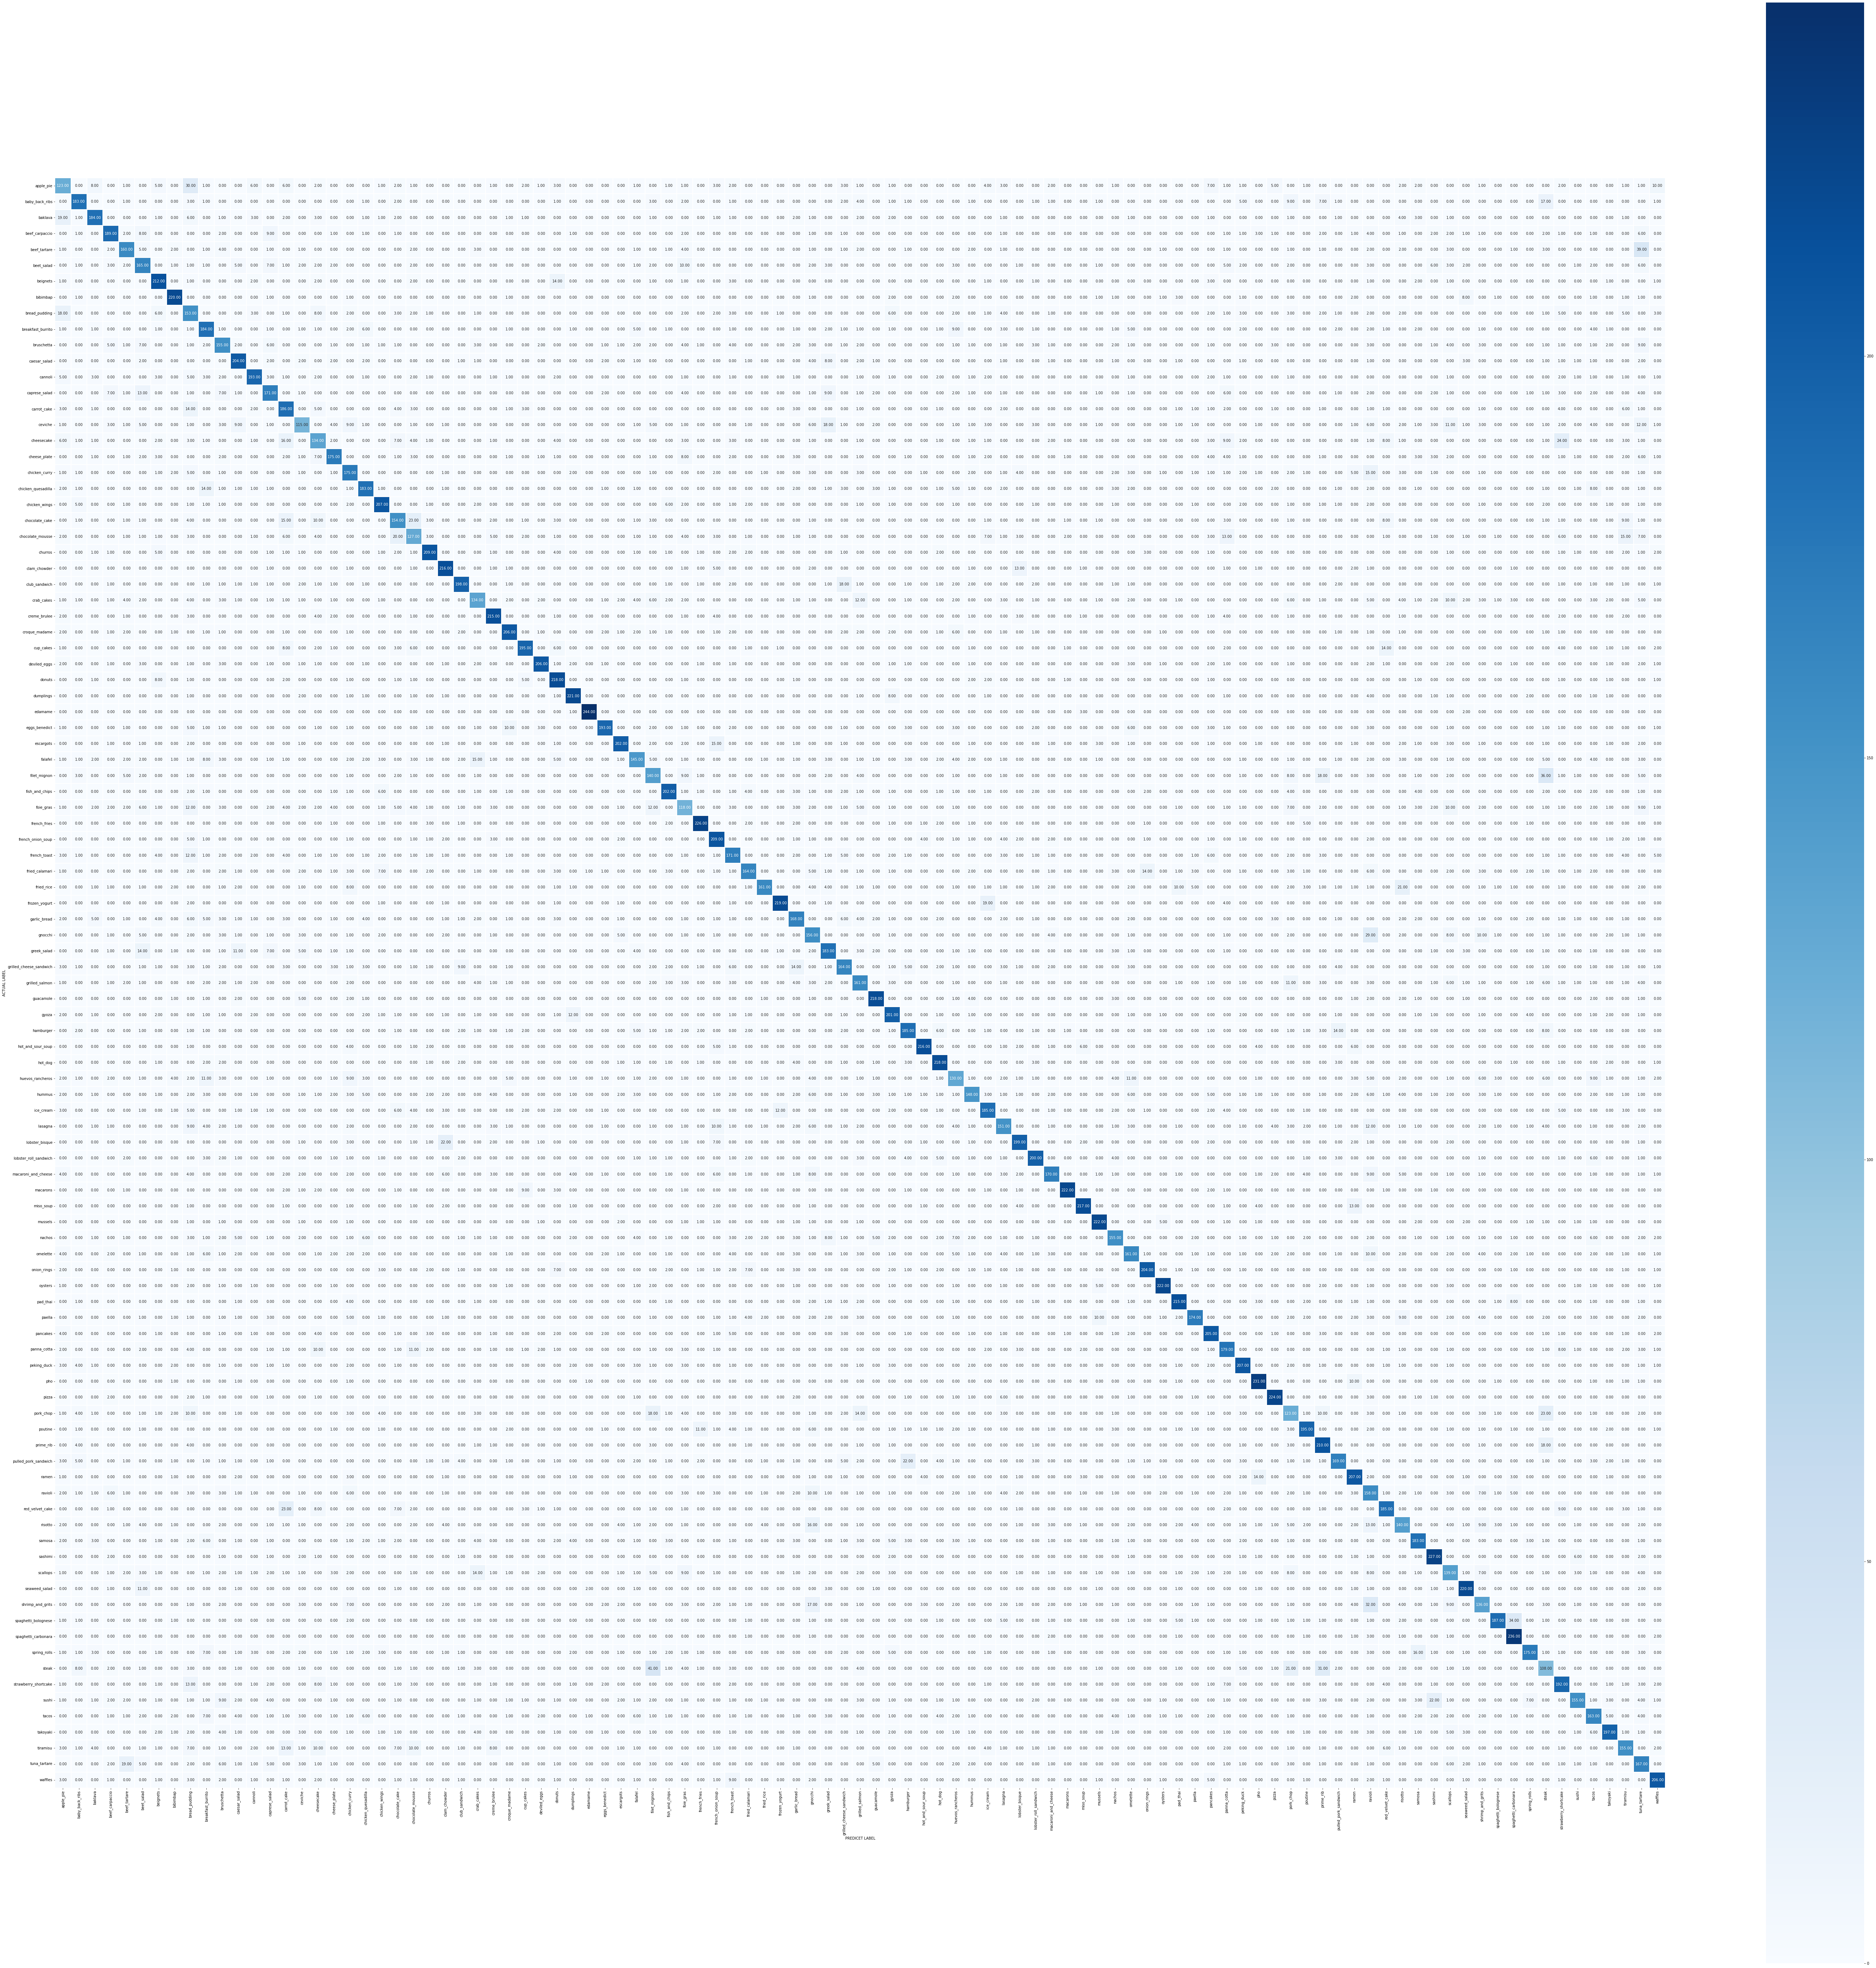

In [56]:
from helperfuncs import plot_confusion_matrix
plot_confusion_matrix(cm,class_names,figsize=(100,100))

In [59]:
model_data_aug.save("dataaugumentationmodel.h5")

c:\users\harshvardhan bhosale\onedrive\desktop\foodvision101\venv1\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [60]:
def load_prep_img(filepath,img_shape=256,scale=False):
    img = tf.io.read_file(filepath)
    img = tf.io.decode_image(img,channels=3)
    img = tf.image.resize(img,[img_shape,img_shape])
    if scale:
        return img/255.
    else:
        return img

In [61]:
img = load_prep_img("test1.jpeg")

In [63]:
prediction = model_data_aug.predict(tf.expand_dims(img,axis=0))

In [71]:
y = prediction.argmax(axis=1)
class_names[y[0]]

'dumplings'

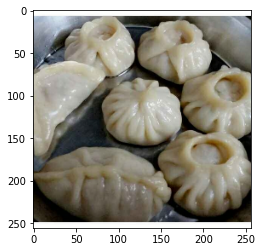

In [73]:
plt.imshow(img/255.)

In [ ]:
#PREDICTION IS CORRECT :)